In [1]:
import matplotlib.pyplot
from models import GeomagneticField
from models import UniformMagneticField
from models import AttitudeControlSystem
from models import Spacecraft
import matplotlib.pyplot as plt
from models import Orbit
import numpy as np
import pandas as pd

# Testing the Geomagnetic Field Model

In [9]:
geomagnetic_field = GeomagneticField()

orbit = Orbit(700, 97.9908*np.pi/180,0,279.066*np.pi/180)

total_time = 0.2684*24*60*60

dt = 2 #s
computation_steps = int(total_time/dt)

position = np.zeros((computation_steps,3))
spherical_coordinates = np.zeros((computation_steps,3))
time = np.zeros(computation_steps)

magnetic_field = np.zeros((computation_steps, 3))
magnetic_field_eci = np.zeros((computation_steps, 3))

for i in range(computation_steps):
    orbit.propagate_orbit(dt)
    position[i] = orbit.orbital_position.copy()

    spherical_coordinates[i][0] = np.sqrt(position[i][0]**2 + position[i][1]**2 + position[i][2]**2)
    spherical_coordinates[i][1] = np.arcsin(position[i][2]/spherical_coordinates[i][0])
    spherical_coordinates[i][2] = np.arctan2(position[i][1],position[i][0])

    spherical_coordinates[i][0] = spherical_coordinates[i][0]/1000
    spherical_coordinates[i][1] = spherical_coordinates[i][1]*180/np.pi
    spherical_coordinates[i][2] = spherical_coordinates[i][2]*180/np.pi

    if i == 0:
        time[i] = 2020
    else:
        time[i] = time[i-1] + dt/(60*60*24*365)

    magnetic_field[i] = geomagnetic_field.evaluate_field(time[i], spherical_coordinates[i][0] - 6371, spherical_coordinates[i][1], spherical_coordinates[i][2], coordinate_systen='TSC')

    magnetic_field_eci[i] = geomagnetic_field.evaluate_field(time[i], spherical_coordinates[i][0] - 6371, spherical_coordinates[i][1], spherical_coordinates[i][2], coordinate_systen='ECI')

## Orbital Position in Cartesian Coordinates

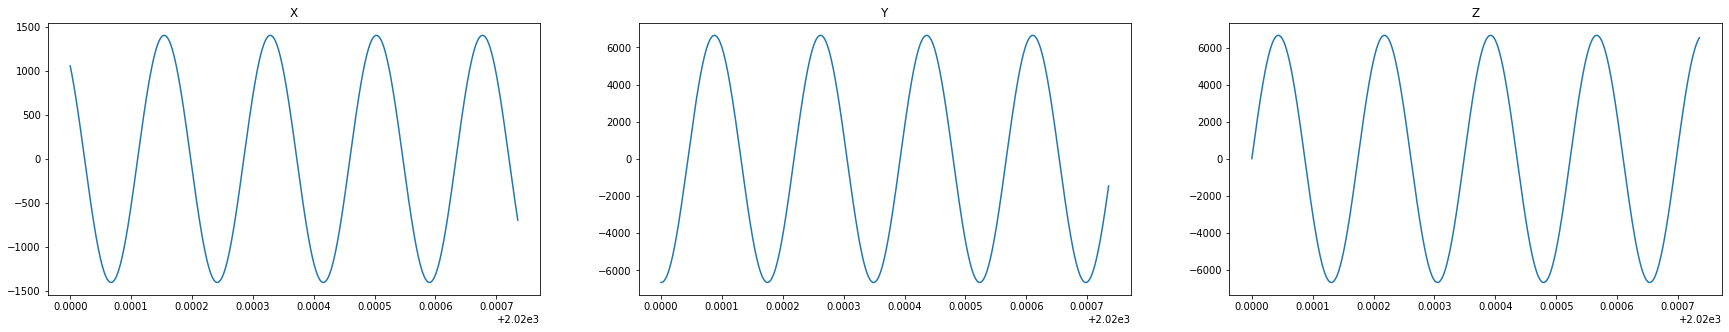

In [10]:
fig, ax = plt.subplots(1,3,figsize=(30,5))

ax[0].set_title('X')
ax[0].plot(time,position.T[0]/1000)
ax[1].set_title('Y')
ax[1].plot(time,position.T[1]/1000)
ax[2].set_title('Z')
ax[2].plot(time,position.T[2]/1000)
plt.show()

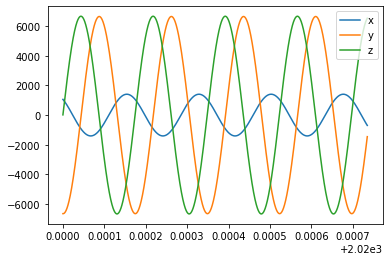

In [11]:
plt.plot(time,position.T[0]/1000)
plt.plot(time,position.T[1]/1000)
plt.plot(time,position.T[2]/1000)
plt.legend(['x','y','z'])
plt.show()

## Orbital Position in Spherical Coordinates

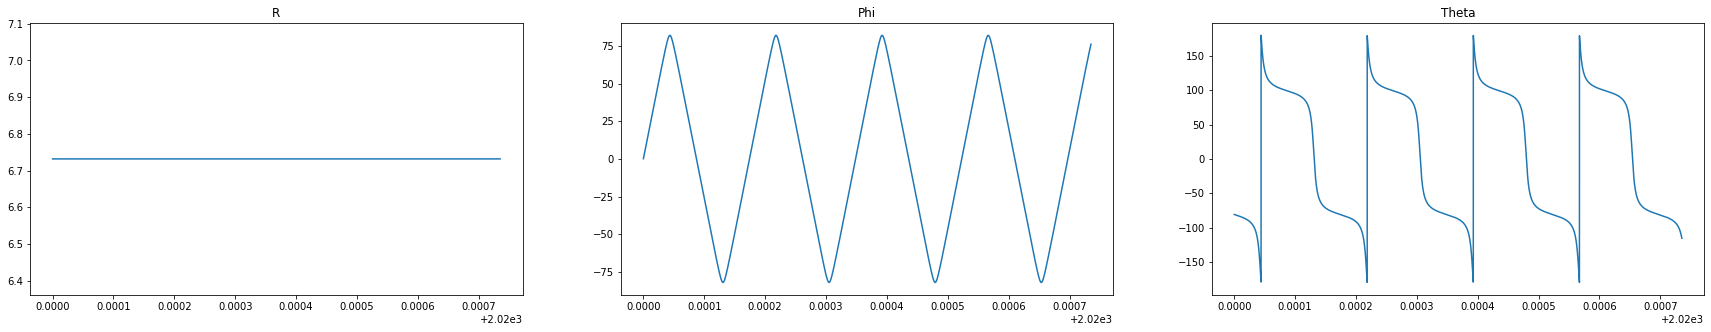

In [12]:
fig, ax = plt.subplots(1,3,figsize=(30,5))

ax[0].set_title('R')
ax[0].plot(time,spherical_coordinates.T[0]/1000)
ax[1].set_title('Phi')
ax[1].plot(time,spherical_coordinates.T[1])
ax[2].set_title('Theta')
ax[2].plot(time,spherical_coordinates.T[2])
plt.show()

## Orbit

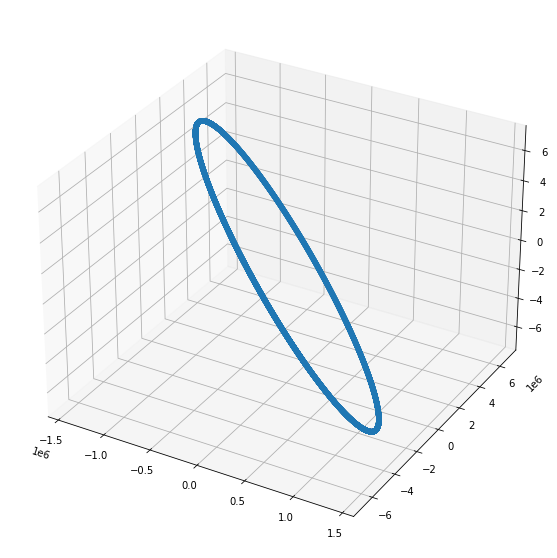

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(position.T[0], position.T[1], position.T[2])

plt.show()

## Geomagnetic Field in Local Spherical Coordinates

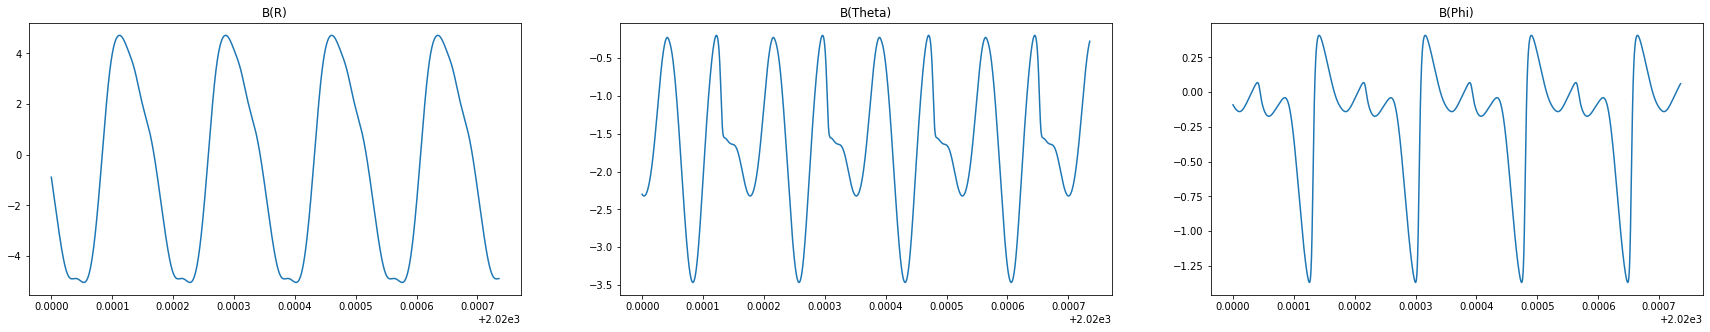

In [14]:
fig, ax = plt.subplots(1,3,figsize=(30,5))

ax[0].set_title('B(R)')
ax[0].plot(time,magnetic_field.T[0]/(10**4))
ax[1].set_title('B(Theta)')
ax[1].plot(time,magnetic_field.T[1]/(10**4))
ax[2].set_title('B(Phi)')
ax[2].plot(time,magnetic_field.T[2]/(10**4))
plt.show()

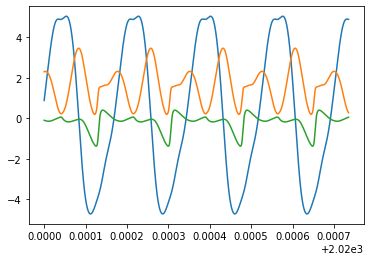

In [15]:
plt.plot(time,-magnetic_field.T[0]/(10**4))
plt.plot(time,-magnetic_field.T[1]/(10**4))
plt.plot(time,magnetic_field.T[2]/(10**4))
plt.show()

## Geomagnetic Field in the Earth Inertial Reference Frame

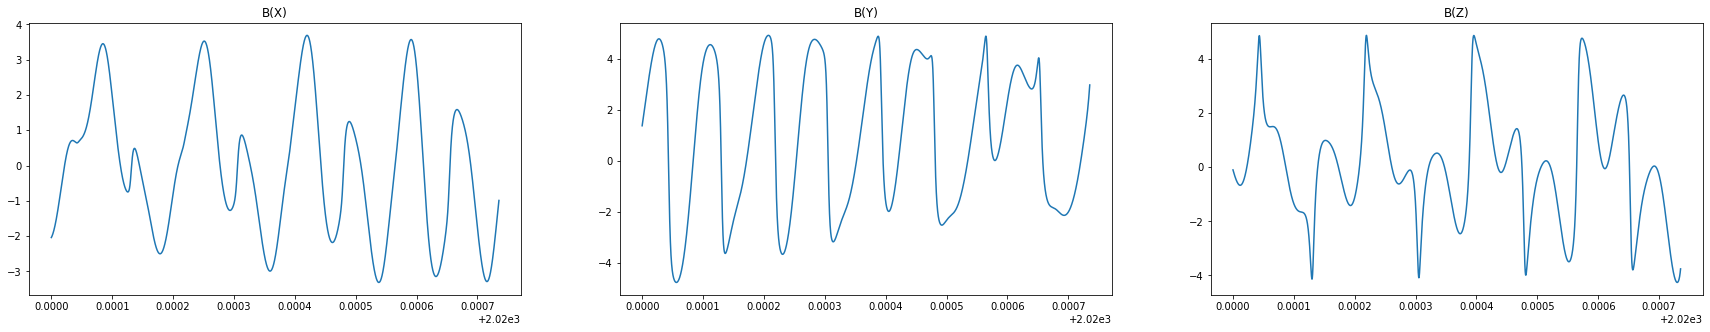

In [16]:
fig, ax = plt.subplots(1,3,figsize=(30,5))

ax[0].set_title('B(X)')
ax[0].plot(time,magnetic_field_eci.T[0]/(10**4))
ax[1].set_title('B(Y)')
ax[1].plot(time,magnetic_field_eci.T[1]/(10**4))
ax[2].set_title('B(Z)')
ax[2].plot(time,magnetic_field_eci.T[2]/(10**4))
plt.show()

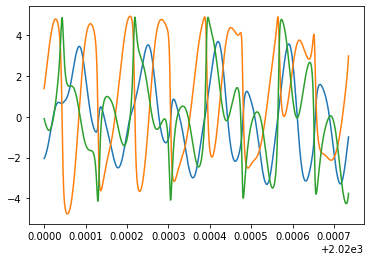

In [17]:
plt.plot(time,magnetic_field_eci.T[0]/(10**4))
plt.plot(time,magnetic_field_eci.T[1]/(10**4))
plt.plot(time,magnetic_field_eci.T[2]/(10**4))
plt.show()

## Actual Geomagnetic Field Waveform

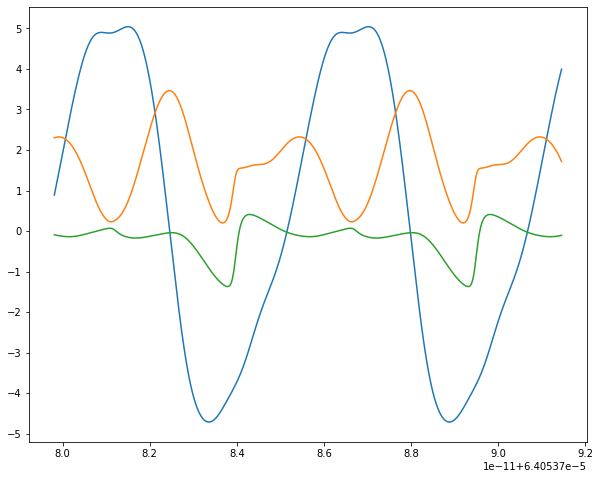

In [18]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(time[:computation_steps//2]/(60*60*24*365),-magnetic_field.T[0][:computation_steps//2]/(10**4))
ax.plot(time[:computation_steps//2]/(60*60*24*365),-magnetic_field.T[1][:computation_steps//2]/(10**4))
ax.plot(time[:computation_steps//2]/(60*60*24*365),magnetic_field.T[2][:computation_steps//2]/(10**4))
ax.set_yticks(np.arange(-5,6,1))
plt.savefig('actual_geomagnetic_field.png',facecolor='white', bbox_inches = 'tight')
plt.show() 

## Expected Geomagnetic Field Waveform

(MEIBO, L. et al. Orbit Propagator and Geomagnetic Field Estimator for NanoSatellite: The ICUBE Mission, International Journal of Physical and Mathematical Science, vol 7 No 7, 2013)


<img src="mag.png" width="600">

## Actual x Expected Geomagentic Field Waveform

<img src="mag.png" width="600"> <img src="actual_geomagnetic_field.png" height="450" width="600">

# Testing the Coupling Between Rigid Body Dynamics and Hysteresis Forces

## Setting Up The Components

In [19]:
hysteresis_bar = AttitudeControlSystem()
hysteresis_bar.add_hysteresis_rod(coercivity=0.8, remanence=0.06, saturation_field=0.08, volume=17.6*10**(-6), direction=np.array([0,1,0]))
rigid_body = Spacecraft(inertia_matrix=np.diag([0.01, 0.01, 0.01]), viscous_damping=0, attitude_control_system=hysteresis_bar)
magnetic_field = UniformMagneticField(field_intensity=20, field_direction=np.array([0,1,0]))

In [20]:
rigid_body.velocity = np.array([19.5*np.pi/180,0,0])
rigid_body.attitude = np.array([np.sin(np.pi/4),0,0,np.cos(np.pi/4)])
magnetic_field_derivative = rigid_body.local_geomagnetic_field_time_derivative(magnetic_field.evaluate_field(),0,0)
hysteresis_bar.hysteresis_rods[0].set_initial_attitude(rigid_body.attitude)
hysteresis_bar.hysteresis_rods[0].set_initial_condition(magnetic_field.evaluate_field(), magnetic_field_derivative)

In [21]:
print('Initial Angular Velocity: ', rigid_body.velocity)
print('Initial Attitude in Euler Angles: ', rigid_body.attitude_euler_angles())
print('Initial Magnetic Field: ', magnetic_field.evaluate_field())
print('Initial Magnetic Field Derivative: ', rigid_body.local_geomagnetic_field_time_derivative(magnetic_field.evaluate_field(),0,0))
print('Hysteresis Rod Field: ', hysteresis_bar.hysteresis_rods[0].B*hysteresis_bar.hysteresis_rods[0].direction)

Initial Angular Velocity:  [0.3403392 0.        0.       ]
Initial Attitude in Euler Angles:  [90.  0.  0.]
Initial Magnetic Field:  [ 0 20  0]
Initial Magnetic Field Derivative:  [ 0.         -0.         -6.80678408]
Hysteresis Rod Field:  [-0.   -0.   -0.06]


## Simulating the Dynamics

In [22]:
total_time = 10*60 #s
dt = 0.01

computation_steps = int(total_time/dt)
velocity = np.zeros((computation_steps,3))
torque = np.zeros((computation_steps,3))
bar_direction = np.zeros((computation_steps,3))
bar_field = np.zeros((computation_steps,3))
bar_field_projection = np.zeros(computation_steps)
field = np.zeros((computation_steps,3))
field_projection = np.zeros(computation_steps)
state = np.zeros(computation_steps)


for i in range(computation_steps):
    velocity[i] = rigid_body.velocity
    bar_direction[i] = rigid_body.attitude_control_system.hysteresis_rods[0].direction
    bar_field[i] = rigid_body.attitude_control_system.hysteresis_rods[0].B
    field[i] = magnetic_field.evaluate_field()
    field_projection[i] = np.dot(field[i], bar_direction[i])
    bar_field_projection[i] =  np.linalg.norm(bar_field[i])
    state[i] = rigid_body.attitude_control_system.hysteresis_rods[0].state
    rigid_body.propagate_state(dt, magnetic_field.evaluate_field(), rigid_body.local_geomagnetic_field_time_derivative(magnetic_field.evaluate_field(), 0,0))
    torque[i] = rigid_body.attitude_control_system.torque

## Angular Velocity Profile

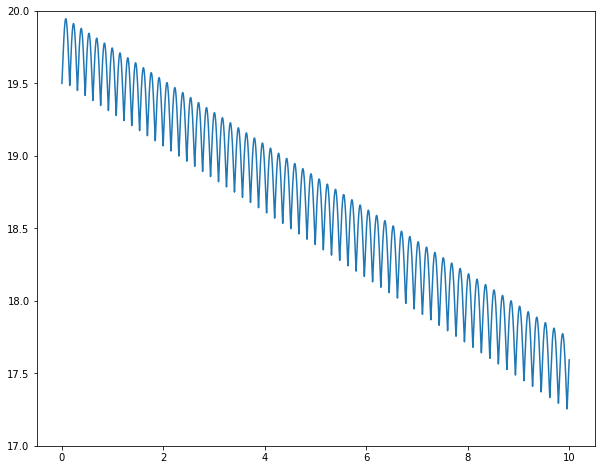

In [23]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(np.linspace(0,10,computation_steps),velocity.T[0]*180/np.pi)
ax.set_ylim([17,20])
plt.savefig('actual_velocity_profile.png',facecolor='white', bbox_inches = 'tight')
plt.show() 

## Generated Torque

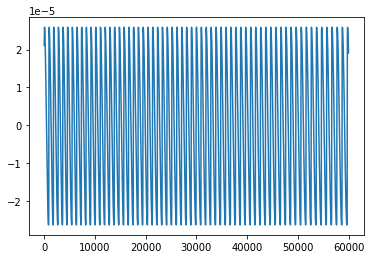

In [24]:
plt.plot(torque.T[0])

## Hysteresis Loop

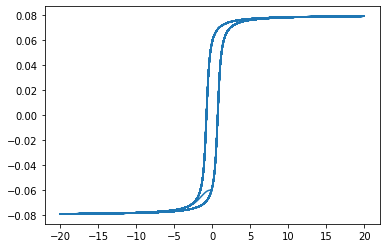

In [25]:
plt.plot(field_projection, bar_field.T[0])

## Expected Velocity Profile

(BURTON, R., STAREK, J., ROCK, S.. A New Method For Simulating Attitude Dynamics of Passively Magnetically Stabilized Spacecraft, Proceedings of the 22nd AAS/AIAA Space Flight Mechanics Meeting, Charleston SC ,2012)


<img src="Velocity.png" width="600">

## Actual x Expected Velocity Profile

<img src="velocity.png" width="600"> <img src="actual_velocity_profile.png" height="450" width="600">